In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as mdj
import pandas as pd
import plumed 
import h5py


In [2]:
traj = mdj.load_dcd('../007_r/outputs_eq/traj.dcd', '../007_r/inputs/protein_ligand.pdb')

In [3]:
traj.n_frames

1000

In [4]:
pdb = mdj.load_pdb('../007_r/inputs/protein_ligand.pdb')
ref_com = mdj.compute_center_of_mass(pdb, select='protein and type!="H"')
coms = mdj.compute_center_of_mass(traj, select='protein and type!="H"')
translation_cv = np.linalg.norm(coms - ref_com, axis=1)
np.max(translation_cv)

0.035224548166025

In [5]:
protein_coms = mdj.compute_center_of_mass(traj, select='protein and type!="H"')
ligand_coms = mdj.compute_center_of_mass(traj, select='resname "MOL" and type!="H"')
r_cv = np.linalg.norm(protein_coms - ligand_coms, axis=1)

In [6]:
colvars_h5 = h5py.File('../007_r/outputs_eq/COLVAR.h5', 'r')
# print(colvars_h5['CV'].shape)
calculated_cvs = np.vstack([r_cv, translation_cv]).T
calculated_cvs.shape
openmm_CVs = np.concatenate([colvars_h5['CV'][:,:6], calculated_cvs], axis=1)
openmm_CVs.shape

(1000, 8)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/ndonyapour/tools_drivers/plumed2-2.8.1/src/lib/libplumedKernel.so" +++


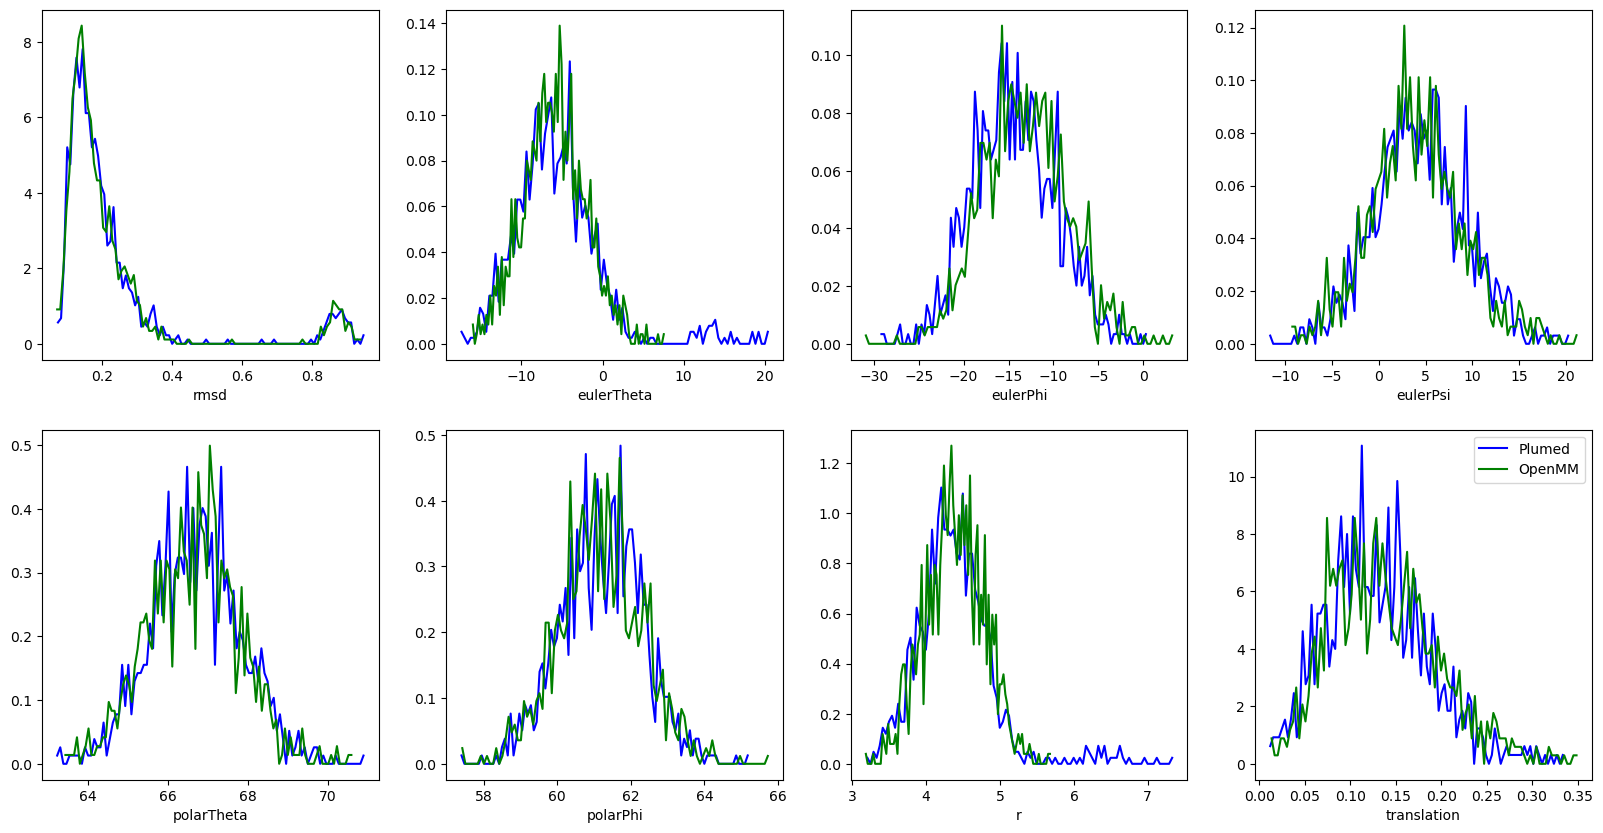

In [12]:

plumed_CVs = plumed.read_as_pandas('../../openmm_plumed/007_r/COLVAR_eq')
plumed_CVs['rmsd'] *= 10
plumed_CVs['translation'] *= 10
plumed_CVs['r'] *= 10
CV_names = ['rmsd', 'eulerTheta', 'eulerPhi', 'eulerPsi', 'polarTheta', 'polarPhi', 'r', 'translation'] 

fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(20, 10)
axes = axes.flatten()
for idx, cv_name in enumerate(CV_names):
    bins, edges = np.histogram(plumed_CVs[cv_name], bins=100, density=True)
    axes[idx].plot(edges[:-1], bins, 'b', label="Plumed")

    if idx in [0, 6, 7]:
        bins, edges = np.histogram(openmm_CVs[:, idx]*10, bins=100, density=True)
    else:
        bins, edges = np.histogram(openmm_CVs[:, idx], bins=100, density=True)

    axes[idx].plot(edges[:-1], bins, 'g', label="OpenMM")
    # center = round(edges[np.argmax([bins])], 2)
    # print(f'{cv_name}, center={center}, range= {edges[np.argmax([bins])] -20.00, edges[np.argmax([bins])] + 20.00} \n')
    # axes[idx].text(0.81, 0.5, f'OpCV={center}', horizontalalignment='center', 
    #                verticalalignment='center', transform=axes[idx].transAxes)
    axes[idx].set_xlabel(cv_name)
plt.legend(loc="best")    
plt.savefig('../analysis/figures/OpenMM_Plumed_r_cvs_hist.png')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/ndonyapour/tools_drivers/plumed2-2.8.1/src/lib/libplumedKernel.so" +++
/tmp/ipykernel_81662/2863556177.py:17: RuntimeWarning: divide by zero encountered in log
  free_energy_op_unbiased = GAS_CONSTANT * TEMPERATURE * np.negative(np.log(bins)) / 4.184
/tmp/ipykernel_81662/2863556177.py:25: RuntimeWarning: divide by zero encountered in log
  free_energy_op_unbiased = GAS_CONSTANT * TEMPERATURE * np.negative(np.log(bins)) / 4.184


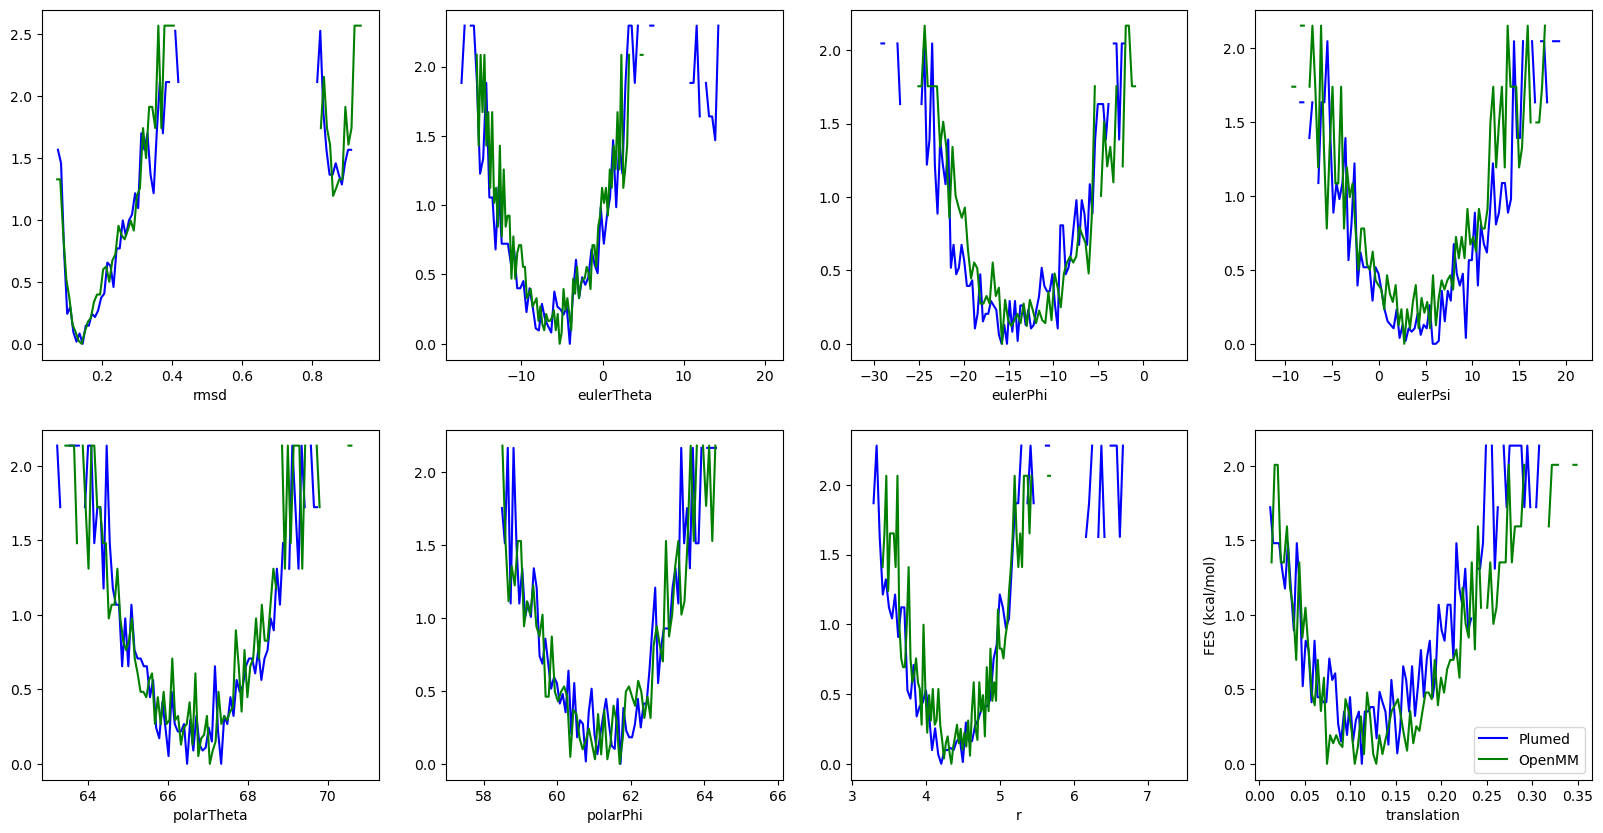

In [14]:
# dG = -RT ln P, R is the gas constant 
TEMPERATURE = 300 #* unit.kelvin
GAS_CONSTANT = 8.314e-3  #kJ/(mol·K)
# unbiased openmm

plumed_CVs = plumed.read_as_pandas('../../openmm_plumed/007_r/COLVAR_eq')
plumed_CVs['rmsd'] *= 10
plumed_CVs['translation'] *= 10
plumed_CVs['r'] *= 10
CV_names = ['rmsd', 'eulerTheta', 'eulerPhi', 'eulerPsi', 'polarTheta', 'polarPhi', 'r', 'translation'] 

fig, axes = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(20, 10)
axes = axes.flatten()
for idx, cv_name in enumerate(CV_names):
    bins, edges = np.histogram(plumed_CVs[cv_name], bins=100, density=True)
    free_energy_op_unbiased = GAS_CONSTANT * TEMPERATURE * np.negative(np.log(bins)) / 4.184
    min_fes = min(free_energy_op_unbiased)
    axes[idx].plot(edges[:-1], free_energy_op_unbiased - min_fes, 'b', label="Plumed")
    
    if idx in [0, 6, 7]:
        bins, edges = np.histogram(openmm_CVs[:, idx]*10, bins=100, density=True)
    else:
        bins, edges = np.histogram(openmm_CVs[:, idx], bins=100, density=True)
    free_energy_op_unbiased = GAS_CONSTANT * TEMPERATURE * np.negative(np.log(bins)) / 4.184
    min_fes = min(free_energy_op_unbiased)
    axes[idx].plot(edges[:-1], free_energy_op_unbiased - min_fes, 'g', label="OpenMM")
    axes[idx].set_xlabel(cv_name)

plt.ylabel("FES (kcal/mol)")
plt.legend()
plt.savefig('../analysis/figures/OpenMM_Plumed_r_cvs_fes.png')